# Audio feature extraction

This is a tutorial on spectral audio features commonly used in audio applications.

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import librosa as lb # module for audio feature extraction
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load an audio file

In [2]:
wavF = '/home/florencia/whales/data/Vocal-repertoire-catalogue-Pilot-whales-Norway/NPW-33/2009-07-13-J/NPW-033-J-B-090713_f50-8_00_03_29.wav'

## The waveform

Time series of sound

Amplitude of oscilation of air pressure waves

sampling rate:  48000 
waveform size: 55867
1.16389583333


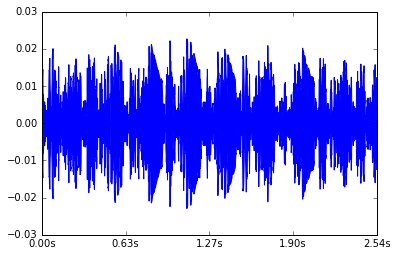

In [28]:
y, sr = lb.load(wavF, sr=None) # default sr=22050
print("sampling rate: ", sr, "\nwaveform size:", len(y))
tf = 1.*len(y)/sr
print(tf)
lb.display.waveplot(y)

## Spectrogram

Is a useful way to represent an audio signal in terms of its frequency components
and is given by the square of the magnitude of the STFT

$P_i(k) = \frac{1}{N} \left| S_i(k) \right| ^2$

Computing the short time fourier tranform along a framed signal.

For visualisation purposes worth looking at the spectrogram in logsale.
We can use librosa's logamplitude function to log scale the spectrogram within (amin=1e-10, top_db=80.0). The obtained spectro is proportional to the log spectro.


Table of parameters


| Waveform \
|---|---|
| sr | seconds  | sampling rate  |
| f | Hz  | Nyquist frequency  |
| Spectrum |
|---|
| NFFT  |   | short time Fourier transform  |
|---|
| Mel-spectrum |
|---|---|---|
| n_mels | |number of Mel filters|
|---|

#freqs: 513 
#times: 110 
NFFT: 1024


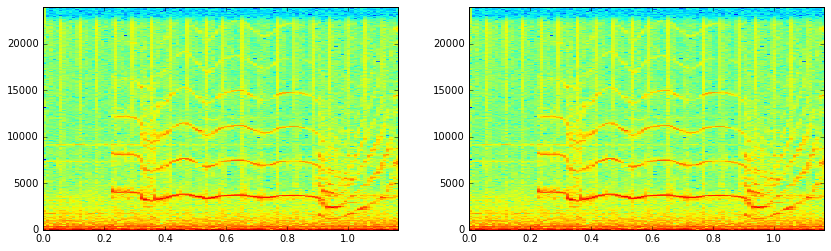

In [124]:
NFFT = 2**10
overlap = 0.5
spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, hop_length=int(NFFT*overlap))
nf, nt =  np.shape(spec_y)
print("#freqs:", nf, "\n#times:", nt, "\nNFFT:", n_fft)
fr = np.linspace( 0, sr/2, nf)
t = np.linspace( 0, tf, nt)
#X, Y = np.meshgrid( fr, t)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.imshow(np.log(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])
plt.subplot(122)
plt.imshow(lb.core.logamplitude(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])

#librosa.display.specshow(np.log(spec_y ), sr=sr)

### Mel spectrum

A scaled version of the spectrogram that resambles sound perception.
Prioritizes lower frequencies.
A mapping between the linear frqeuncies in [Hz] into the Mel scale can be obtained with
$$
M(f) = 1125 \ln (1 + f/700)
$$

The Mel-spectrum can be computed applying a filterbanck over the spectrogram.

For that we first create the **Mel-filterbank**, a non linar wrapping of the linear freqeuncies (in Hz) to the Mel-scale:


mel basis: (128, 513) 
spectrogram: (513, 110)


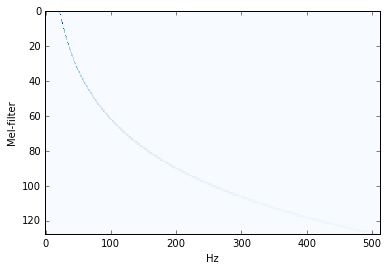

In [125]:
n_mels = 128
mel_basis = lb.filters.mel(sr, n_fft, n_mels=n_mels, fmin=1000)
print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y))

plt.imshow(mel_basis, aspect='auto', cmap=plt.cm.Blues, interpolation='nearest')
plt.ylabel('Mel-filter')

plt.xlabel('Hz')

### The Mel-filters

The filters are scaled to have approximately constant energy.

#mel filters : 128
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


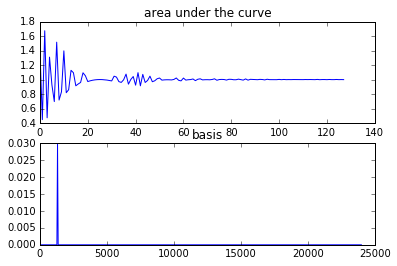

In [126]:
print("#mel filters :", len(mel_basis))
### Area of the mel filters
plt.subplot(2,1,1)
plt.title('area under the curve')
plt.plot([np.trapz(mel_basis[i,:], fr) for i in np.arange(len(mel_basis))])

### plot filters
plt.subplot(2,1,2)
plt.title('basis')
plt.plot(fr, mel_basis[10,:])
#plt.plot(mel_basis[10,:])
#plt.plot(mel_basis[50,:])
#plt.plot(mel_basis[100,:])
#plt.plot(mel_basis[120,:])

print(mel_basis[10,10:25])

Applying the filterbank to the spectrum (not in log scale) we obtain the **Mel-spectrogram**

mel basis: (128, 513) 
spectrogram: (513, 110) 
mel-spectrum (128, 110)


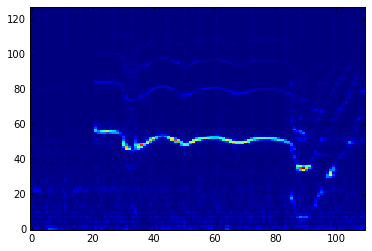

In [127]:
mel_spec_y = np.dot(mel_basis, spec_y) # matrix mutiplication
print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y),
      "\nmel-spectrum", np.shape(mel_spec_y))

plt.imshow(mel_spec_y, aspect='auto', origin='bottom', interpolation='nearest')

Now in log-scale.

Because the n_fft determines the number of frquency channels in the spectrogram (=n_fft/2), when the the number of mel filters is close the n_fft is not posible to map the linear frequency into the Mel-scaled ones, especially at lower frquencies where more resolution is demanded.

range (log): -3.331658793 -13.158561917 
range (lb-log amp): -14.4692102938 -57.1469083034


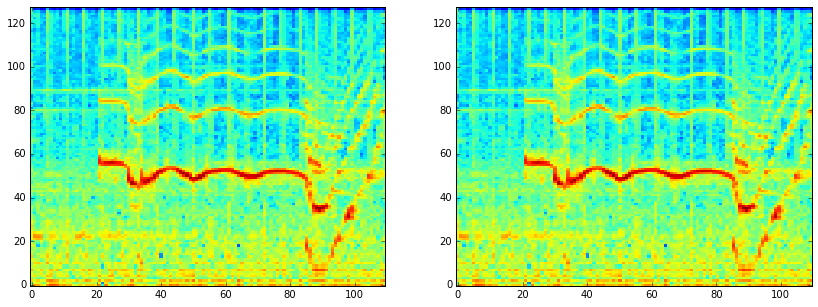

In [128]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(np.log(mel_spec_y), aspect='auto', origin='bottom', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(lb.core.logamplitude(mel_spec_y), aspect='auto', origin='bottom', interpolation='nearest')

print('range (log):', np.max(np.log(mel_spec_y)), np.min(np.log(mel_spec_y)), 
      '\nrange (lb-log amp):',
      np.max(lb.core.logamplitude(mel_spec_y)), np.min(lb.core.logamplitude(mel_spec_y)))

## MFCC

In [129]:
log_mel_spec_y = lb.core.logamplitude(mel_spec_y)
print(log_mel_spec_y.shape[0])

128


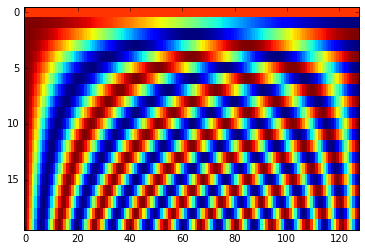

In [130]:
n_mfcc = 20
dct_filt = lb.filters.dct( n_mfcc, n_mels)
plt.imshow(dct_filt, aspect='auto', interpolation='nearest')

In [131]:
mfcc_y = np.dot(dct_filt, log_mel_spec_y)

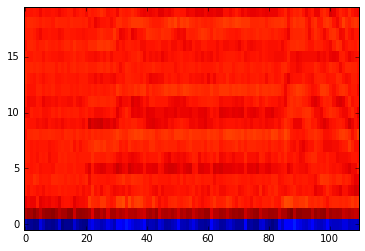

In [132]:
plt.imshow(mfcc_y, aspect='auto', origin='bottom', interpolation='nearest')